<a href="https://colab.research.google.com/github/ciaochiaociao/big_data_systems/blob/main/NanoDB_Storage_and_Querying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 145 -- How to build a "toy" NanoDB?

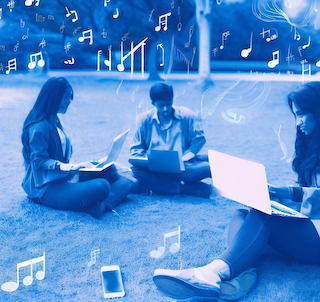




**Learning goals**
* Systems primer on IOdevices (e.g. RAM, SSDs)
* Physical storage in DbFiles
* Common Big Data Algorithms: HashPartitions and BigSort
* Common JOIN Algorithms: BNLJ, SMJ, HPJ
* IO Costs for different algorithms
* Indexing using Hash Tables, hierarchical B+trees

Slides: https://docs.google.com/presentation/d/1PCxSEvxso0eGMBuvA7nksjegO7JeAo_FnFV8bURW-nI/edit#slide=id.g24c78bbb61e_0_32

# [Section 0] Ignore - Visualization Libraries Setup

In [ ]:
def displaySectionCaption(caption, color='coral'):
  html_string = f'<hr><strong><p style="color:{color};font-size:16px;">{caption}</p.</strong>'
  display(HTML(html_string))

# [Section 1] Systems Primer
We study a simplified IO model for HDDs and SSDs in cs145. The model will work well in practice, for our query optimzation and data layout problems. For more details on how the devices work, see Optional reads How HDDs work? How SSDs work?


In [ ]:
import math
from math import ceil, log

# We'll use MBs -- for basic i to MBs
(MB, GB, TB, KB, Bytes) = (1.0, 1024.0, 1024.0*1024.0,
                           1.0/1024.0, 1.0/(1024.0*1024))

# 64 MB-Blocks (default)
PageSizeMB = 64.0*MB
size_of_types = {'int64': 8, 'int32': 4, 'double': 8, 'char': 1} # in bytes

class IOdevice:
  def __init__(self, accessTime, scanSpeed, C_w):
    self.C_r = 1.0  # Cost of reads
    self.C_w = C_w  # Cost of writes relative to reads
    self.accessTime = accessTime
    self.scanSpeed = scanSpeed

  # Read costs: Simple IOcost model using Access time + Scan speeds
  def read_pages_cost(self, numPages):
    # Assume you need to read full pages. (i.e., no partial pages)
    numPages = math.ceil(numPages)
    tsecs = numPages*self.accessTime  # time to access
    tsecs += numPages*PageSizeMB/self.scanSpeed # time to scan
    return (tsecs)

  def write_pages_cost(self, numPages):
    return self.C_w*self.read_pages_cost(numPages)

# Example IO devices in 2024
# Access and Scan speeds in [seconds, MBps], Cw cost of write vs reads.
ram2024 = IOdevice(100*pow(10, -9), 100.0*1024, 1.0) # 100 nanosecs, 100GBps
ssd2024 = IOdevice(10*pow(10, -6), 5.0*1024, 1.0) # 10 microsecs, 5GBps
hdd2024 = IOdevice(10*pow(10, -3), 100.0, 1.0) # 10 millissecs, 100 MBps
# machine to machine over network (modeling a network as an IO device)
m2m1 = IOdevice(1*pow(10, -6), 5.0*1024, 1.0) # 1 micro, 5 GBps

IOdevices1 = {'HDD': hdd2024, 'SSD': ssd2024, 'RAM': ram2024}

In [ ]:
"""
Basic physical table
"""
class Table:
  def __init__(self, sizeInMBs, rowSize):
    self.sizeInMBs = sizeInMBs
    self.rowSize = rowSize
    self.numRows = ceil(self.sizeInMBs/self.rowSize)

    # self.numTuples = numTuples
    self.isSorted = False
    self.isHPed = False

  # P(R) -- number of Pages for table
  def P(self):
    P = ceil(self.sizeInMBs/PageSizeMB)
    return P
  def RowSize(self):
    return self.rowSize
  def T(self):
    return self.numRows
  def SizeInMBs(self):
    return self.sizeInMBs

  # Keeping track of is table sorted, HPed, or neither (default)
  def Sort(self):
    self.isSorted = True
    self.isHPed = False
  def HP(self):
    self.isSorted = False
    self.isHPed = True
  def Reset(self):
    self.isSorted = False
    self.isHPed = False


## Exercise 1.1 Problems

In [ ]:
# Spotify Songs Table [songid: int64, title: text, name: text, genre: text]
#    -- Size of row = 8 bytes (int64) + avg size of title+name+genre.
#    -- Assume avg row size = 1024 Bytes
songs_rowSize = 1024.0*Bytes
songs_numRows = 500000000.0 # 500 million songs

"""Problem 1:
Calculate the size (MBs) of SongsTable, and num pages."""
songs_sizeinMBs = songs_rowSize*songs_numRows/MB
SongsTable = Table(songs_sizeinMBs, 1024.0*Bytes)
print(f'Problem1: {SongsTable.SizeInMBs()=} (MBs), {SongsTable.P()=} pages')

"""Problem 2: Read costs
Compute the cost in seconds to read 100 pages from the SongsTable"""
print(f'Problem2:')
print(f'  {ram2024.read_pages_cost(100)=} secs')
print(f'  {ssd2024.read_pages_cost(100)=} secs')
print(f'  {hdd2024.read_pages_cost(100)=} secs')

"""Problem 3: Effect of caching
Read 200 pages. 1st check RAM.
- Cache hit of 90% in RAM.
- For RAM cache misses (the other 10%), 75% are in SSD and 25% are in HDD."""
cost = ram2024.read_pages_cost(200)
cost += ssd2024.read_pages_cost(0.1*0.75*200)
cost += hdd2024.read_pages_cost(0.1*0.25*200)
print(f'Problem3: 90% cache hit rate for 200 pages (secs): {cost}' )

In [ ]:

"""Problem 4:
Suppose you need to read 30 pages and write 10 blocks to the SongsTable.
Calculate the total cost (secs) if the table is on different IO devices."""
num_read_pages = 30
num_write_pages = 10
print(f'Problem4:')
for io in [ram2024, ssd2024, hdd2024]:
  read_cost = io.read_pages_cost(num_read_pages)
  write_cost = io.write_pages_cost(num_write_pages)
  total_cost = read_cost + write_cost
  print(f"  Cost for read {num_read_pages} + write {num_write_pages} pages: \
          {total_cost} secs")

"""Problem 5:
Suppose you want to read 1 page from "network RAM". That is, RAM from another
machine, versus local SSDs or HDDs. Calculate the different costs.
"""
local_ram = ram2024.read_pages_cost(1)
local_hdd = hdd2024.read_pages_cost(1)
local_ssd = ssd2024.read_pages_cost(1)
# read data from RAM on another machine
network_ram = ram2024.read_pages_cost(1) + \
              m2m1.read_pages_cost(1) + \
              ram2024.write_pages_cost(1)
print(f'{local_ram=} {local_hdd=} {local_ssd=} {network_ram=}')

# [Section 2] NanoDB: How to store DbFiles and execute JOINs

In [ ]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import math, matplotlib.axes as axes, matplotlib.pyplot as plt, matplotlib.colors as mcolors
from enum import Enum
import pickle, os

class Verbose(Enum):
  SILENT = 0
  NORMAL = 1
  VERBOSE = 2
  LISTPAGES = 3

# adjust verbose mode for more debug information
verbosity = Verbose.LISTPAGES

try:
  os.mkdir('join')
  os.mkdir('tmp')
except:
  pass
##
# DbFile: Mimic how to store data on disk, managed by a RAM buffer.
class DbFile:
    def __init__(self, values=None, pages=None, k=None, filepfx = ''):
      self.filepfx = filepfx
      self._pad = (None, None)
      if pages: # Construct new pages based on copying pages
        self.pages = pages
        self.k = len(pages[0])
        self.P = len(pages)
        self.n = 0
        for i, p in enumerate(pages):
          self.n += len(p)
          while len(p) < self.k:
            self.pages[i].append(self._pad)
      elif not values: # Empty page
        self.pages = []
        self.P = 1
        self.k = k
        self.n = 0
      else: # New page based on copying values
        self.k = k
        self.n = len(values)
        self.pages = [[self._pad] * k for i in range(math.ceil(len(values)/self.k))]
        self.P = math.ceil(len(values)/k)
        for i, value in enumerate(values):
          page_num, index = divmod(i, k)
          self.pages[page_num][index] = value
      self.save_to_disk()

    # Mimics reading num-th page.
    #    If the page is in RAM, return the same page. If not, read from disk.
    def read_page(self, page_num):
      if self.pages == []:
        return []
      return self.pages[page_num]
    # Mimics writing num-th page with page_data.
    #    If page in RAM, change the values in page.
    #    If not, read page from disk, and update values.
    def write_page(self, page_num, page_data):
        self.pages[page_num] = page_data

    # Update a specific page value
    def update_page(self, idx, new_val):
      pnum, pidx = divmod(idx, self.k)
      page_data = self.pages[pnum]
      page_data[idx] = new_val
      self.write_page(pnum, page_Data)

    # Read i-th row. I.e., find (page, location in page) and return row
    def read_ith(self, idx):
      pnum, pidx = divmod(idx, self.k)
      return self.read_page(pnum)[pidx]

    def is_row_valid(self, row):
      return row != self._pad

    # Append values to the end of the DbFile
    def append_page(self, value):
      # add to last page. Or create new page
      def new_page(value):
        # need new page
        newpage = [(None, None)] * self.k
        newpage[0] = value
        self.pages.append([value] + [(None, None)]*(self.k-1))
        self.P = len(self.pages)
      self.n += 1
      if len(self.pages) > 0:
        last_page = self.pages[self.P -1]
        for i in range(len(last_page)):
          if last_page[i] == (None, None):
            last_page[i] = value
            return
      new_page(value)
      self.save_to_disk()

    # Splits files into smaller files
    def split_files(self, num_pages_per_split):
      split_files = []
      for i in range(0, self.P, num_pages_per_split):
        end = min(i+num_pages_per_split, self.P)
        tmpp = self.pages[i:end]
        tmpfdb = DbFile(pages=tmpp,
                   k=self.k, filepfx = "tmp/" + self.filepfx+str(i))
        split_files.append(tmpfdb)
      return split_files

    # Store as file
    def save_to_disk(self):
        """Save the current DbFile object to disk."""
        file_name = self.filepfx + '.db'
        with open(file_name, 'wb') as file:
            pickle.dump(self, file)
        #print(f"DbFile saved to {file_name}")

    @classmethod
    def load_from_disk(cls, filepfx):
        """Load a DbFile object from disk."""
        file_name = filepfx + '.db'
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"No such file: {file_name}")
        with open(file_name, 'rb') as file:
            db_file = pickle.load(file)
        print(f"DbFile loaded from {file_name}")
        return db_file

    ## Functions for visuals
    # Below is visualization code [optional read]
    def print_pages(self):
      for p in range(self.P):
        print("Page", p, ":", self.read_page(p))
    def read_all_pages(self):
      return [self.read_page(p) for p in range(self.P)]
      ## Helper functions for us to see pages
    def format_cell(self, series):
      return ', '.join(str(val) for val in series)

    def print_file(self):
      tdf = self.read_all_pages()
      dfList = [[self.filepfx, len(tdf), self.format_cell(tdf)]]
      df = pd.DataFrame(dfList, columns=["DbFiles", 'Num Pages', "Pages"])
      display(HTML(
          df.to_html(index=False, classes=['table', 'table-bordered'],
                     header=['<th style="word-wrap: break-word; max-width: 30px;">Pages</th>'])))


In [ ]:
import random, heapq, string

def gen_random_string(string_length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

# create sample tables with n-rows of [<int, string of 'l' chars>]
def gen_random_rows(l, n):
  return [(random.randint(1, 500), gen_random_string(l), '..') for i in range(n)]

# Generate n rows with integer keys in descending order and random strings
def gen_reverse_rows(l, n):
  return [(100 - i, gen_random_string(l), '..') for i in range(n)]
random.seed(3141)


In [ ]:
""" Generate a Songs table with 100 tuples, with k=3 rows per page"""
Songs = DbFile(values=gen_random_rows(2, 100), k=3, filepfx='Songs')
Songs.print_file()

In [ ]:
""" Generate a Listens table with 100 tuples, with k=7 rows per page"""
Listens = DbFile(values=gen_random_rows(2, 100), k=7, filepfx='Listens')
Listens.print_file()

In [ ]:
""" Generate a Listens table with 1000 tuples, with k=22 rows per page"""
Listens = DbFile(values=gen_random_rows(2, 1000), k=22, filepfx='Listens')
Listens.print_file()

In [ ]:
# Read the DbFile into Songs2 -- same data
Songs2 = Songs.load_from_disk('Songs')
Songs2.print_file()

In [ ]:
"""
  Algorithms supported in a DB for sorting, hashing, JOINs, etc"""
def genFilePath(str):
  return str.split('/')[-1]

class Algos:
  def __init__(self, B, verbose=False): # B (RAM buffer) to keep Pages
    self.B = B
    self.verbose = verbose
    return
  ##
  # Functions for Sorting
  def split(self, R):
    return R.split_files(self.B)

  # Sort a given (small) file in RAM
  def sortRAM(self, v_list, R):
    concat = []
    for l in v_list: # only use valid rows (ignore padded 'None' rows)
      l = list(filter(lambda x: R.is_row_valid(x), l))
      concat += l
    s_concat = sorted(concat, key=lambda x:x[0])
    sublists = [s_concat[i:i + R.k] for i in range(0, len(s_concat), R.k)]
    return DbFile(pages=sublists, k=R.k, filepfx=R.filepfx)

  # MergeBWay(Rlist): Merge B partially sorted files, into a bigger sorted file
    # Step 1: Read 1st page of each of the B files. Create a small heap in RAM.
    # Step 2: Repeat below steps until all data is sorted
    # Step 2a:   Select smallest value from the heap, Append to the output file
    # Step 2b:   Read the next value from the file associated with value in 2a
    #            and add it into heap
  def mergeBway(self, Rlist):
    if not Rlist:
      return []
    out = DbFile(values=None, k=Rlist[0].k, filepfx=Rlist[0].filepfx)
    heaps = []
    # Step 1: Read 1st values.
    # Also, keep a heap to track values, and which file/page they are from
    for b in range(len(Rlist)):
      page = Rlist[b].read_page(0)
      # value from (sort key, row, bth file, 0th page, 0th slot)
      heapq.heappush(heaps, (page[0][0], page[0], b, 0))

    while (heaps): # Step 2a
      cur_min, row, fnum, vidx = heapq.heappop(heaps)
      out.append_page(row)
      # Step 2b: Read the next value (after cur_min in same file)
      vidx += 1
      if vidx < Rlist[fnum].n:
        row = Rlist[fnum].read_ith(vidx)
        heapq.heappush(heaps, (row[0], row, fnum, vidx))
    return [out]

  # BigSort(R): Sort a big file (does not fit in RAM)
    # 1. Split big file into many small files of B pages each
    # 2. Sort each small file (in RAM)
    # 3. Merge B sorted files at a time into bigger files. Repeat until done
  def BigSort(self, R):
    # Step 1 and 2
    split_files = self.split(R)
    merged_files = [[self.sortRAM(fsplit.read_all_pages(), R) \
                     for fsplit in split_files]]
    numpass = 0

    # Step 3
    while (len(merged_files[numpass]) > 1):
      mfiles = []
      for start in range(0, len(merged_files[numpass]), self.B):
        end = min(start + self.B, len(merged_files[numpass]))
        mfiles += self.mergeBway(merged_files[numpass][start:end])
      merged_files.append(mfiles)
      numpass += 1
    self.print_files(merged_files, add_sfx=True,
                     caption=f'Big Sort {R.filepfx}',
                     subcaption=f'[Pass #]')
    return merged_files[numpass]

  ## Functions for Hashing
  #
  # HP(R): Hash partition a big file
    # Step 1: Set up B partitions (stored as DbFiles)
    # Step 2: Read each page of R into RAM.
    # Step 3: Hash each value h(v). Append to the h(v)th partition.
  def HashP(self, R):
    # internal fn to hash a given integer or string
    import hashlib
    def hash_value(value):
      if isinstance(value, int):
        return hash(value) % self.B
      sha256 = hashlib.sha256()
      sha256.update(value.encode('utf-8'))
      return int(sha256.hexdigest(), 16) % self.B

    ## Step 1
    hash_files = [DbFile(values=[], k=R.k, filepfx="tmp/"
                         + genFilePath(R.filepfx) + f'.{i}') \
                  for i in range(self.B)]
    # Steps 2 and 3
    for i in range(R.P):
      page = R.read_page(i) ## Step 2
      for j in range(len(page)): ## process values in RAM
        if R.is_row_valid(page[j]):
          h = hash_value(page[j][0])
          hash_files[h].append_page(page[j]) # Step 3
    self.print_files([hash_files],
                     caption=f'HashPartiton: {R.filepfx}')
    return hash_files

  ## Functions for JOINs
  #

  # BNLJ(R, S): Joins R and S using a block-nested loop algo
    # Step 1. Read R's pages into RAM, 'B' pages at a time.
    #    (And cache these 'B' pages in RAM)
    # Step 2. Read S's pages to join with R's cached pages.
  def BNLJ(self, R, S, outk):
    out = DbFile(values=[], k=outk,
                 filepfx="join/" + genFilePath(R.filepfx) + \
                 '-bnlj-' + genFilePath(S.filepfx))
    for i in range(0, R.P, self.B): # Step 1
      pages_R = [R.read_page(j) \
                 for j in range(i, min(i + self.B, R.P))] # IO-cost
      for j in range(S.P): # Step 2
        page_S = S.read_page(j) # IO-cost
        for p in pages_R: # Below is in RAM. I.e. IO-cost = 0
          for r in p:
            if not R.is_row_valid(r):
              continue
            for s in page_S:
              if not S.is_row_valid(s) or r[0] != s[0]:
                continue
              out.append_page((r[0],) + r[1:] + s[1:]) # IO-cost to append
    self.print_files([[out]],
                     caption=f'BNLJ: {R.filepfx} JOIN {S.filepfx}')
    return out


  # HPJ(R, S): Join R and S with Hash Partition Joins
    # Step 1: HP(R), HP(S)
    # Step 2: For each partition, run BNLJ(). Finally append
  def HPJ(self, R, S, outk):
    # Step 1
    rhash = self.HashP(R)
    shash = self.HashP(S)
    hpjout = []
    # Step 2
    for i in range(self.B):
      hpjout.append(self.BNLJ(rhash[i], shash[i], outk))

  # SMJ(R): SortMerge Join R and S
    # Step 1: Sort R and S (stored as DbFiles)
    # Step 2: Iterate thro' each page of R and S, in sequence
  def SMJ(self, inR, inS, outk):
    # Step1
    R = self.BigSort(inR)[0]; S = self.BigSort(inS)[0]

    out_file = DbFile(values=[], k = outk, filepfx="join/"
                      + genFilePath(R.filepfx) +  "-smj-" + genFilePath(S.filepfx))
    ridx = 0; sidx = 0

    # Step 2: Merge 2 sorted files.
    while (ridx < R.n and sidx < S.n):
      r = R.read_ith(ridx); s = S.read_ith(sidx)
      if r[0] < s[0]:
        ridx += 1
      if r[0] > s[0]:
        sidx += 1
      if r[0] == s[0]:
        # Scan through all equal values. Backup when necessary
        # E.g., R=[... 'bb', 'bb', 'cc', ...] and S=[...'bb', 'cc', 'cc', ...]
        # Make sure to match all 'bb' and 'cc's.
        backup_sidx = sidx
        while r[0] == s[0] and sidx < S.n:
          out_file.append_page((r[0],)+r[1:]+s[1:])
          sidx += 1
          s = S.read_ith(sidx)
        ridx += 1
        sidx = backup_sidx

    self.print_files([[out_file]],
                     caption=f'SMJ: {inR.filepfx} JOIN {inS.filepfx}')
    return out_file

  def format_cell(self, series):
    return ', '.join(str(val) for val in series)

  def print_files(self, mfiles, add_sfx=False, caption="", subcaption=""):
    displaySectionCaption(caption)
    for i, mfile in enumerate(mfiles):
      pd.options.display.max_colwidth = 10
      displaySectionCaption(f'====>> {subcaption} {i}')
      for j, dfile in enumerate(mfile):
        filesfx = '-p' + str(i) + "-f" + str(j) if (add_sfx) else ""
        dfile.filepfx += filesfx
        dfile.print_file()


## [2.1] Examples for Sorting, Hashing, JOINs

In [ ]:
import random, heapq, string

def gen_random_string(string_length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

# create sample tables with n-rows of [<int, string of 'l' chars>]
def gen_random_rows(l, n):
  return [(random.randint(1, 500), gen_random_string(l), '..') for i in range(n)]
random.seed(3141)

""" Generate a Songs table with 100 tuples, with k=3 rows per page"""
Songs = DbFile(values=gen_random_rows(2, 100), k=3, filepfx='Songs')
Songs.print_file()


In [ ]:
algoV = Algos(4, verbose=True) # algorithms in verbose mode
algo = Algos(4) # algorithms in non-verbose mode
SongsSorted = algoV.BigSort(Songs) # Sort Songs table

In [ ]:

# Generate n rows with integer keys in descending order and random strings
def gen_reverse_rows(l, n):
  return [(100 - i, gen_random_string(l), '..') for i in range(n)]
""" Generate a RevRecos table with 100 tuples, with k=3 rows per page"""
RevRecos = DbFile(values=gen_reverse_rows(2, 100), k=3, filepfx='RevRecos')
RevRecos.print_file()
RevRecosSorted = algoV.BigSort(RevRecos)


In [ ]:
""" Generate a Listens table with 100 tuples, with k=7 rows per page"""

random.seed(4242)
Listens = DbFile(values=gen_random_rows(2, 100), k=7, filepfx='Listens')
Listens.print_file()

ListensSorted = algoV.BigSort(Listens) # Sort Listens table

In [ ]:
algoV.BNLJ(Songs, Listens, 4)

In [ ]:
algoV.HPJ(Songs, Listens, 4)

In [ ]:
algoV.SMJ(Songs, Listens, 4)

# [Section 3] JOINs, GROUPBY IO Costs

[Material from Lectures 5, 6, 7, 8]

We need to model a real-world complex system. We use a simple model for good approximations of IO costs (and not get bogged down by other factors -- e.g., data caching, contentions in IO, etc.)

In [ ]:
################################################
## IO Cost Equations
################################################
class DBOptimizer:
  # setting up IO, e.g, Read/Write costs in IOs
  def __init__(self, B, C_r, C_w):
    self.B = B
    (self.C_w, self.C_r) = (C_w, C_r)

  ##########
  # Sort(R) and HP(R)
  def SortCost(self, R):
    # assume repacking optimization, and B-way merge. Assume B ~= B+1
    P_R = R.P()
    if P_R == 0:
      return 0
    return (self.C_r+self.C_w)*P_R*(ceil(log(P_R/(2*self.B), self.B)) + 1)

  def HPCost(self, R):
    # C_r*R.P() to read pages, and C_w*R.P() to write out partition
    return ((self.C_r+self.C_w)*R.P())

  def Sort(self, R):
    R.Sort()
    return self.SortCost(R)
  def HP(self, R):
    R.HP()
    return self.HPCost(R)

  #########
  #### JOIN Algorithms
  #### We'll handle OUT outside the function.
  # JOIN Algo1: P(R), P(S) and B: comute BNLJ IO Cost.
  def BNLJCost(self, R, S):
    ioCost = self.C_r*(R.P() + S.P()*ceil(R.P()/self.B))
    if R == S: # self-join: assume no special optimization.
      pass     # TODO(student): Think if you can improve BNLJ for self-joins?
    return ioCost

  # JOIN Algo2: P(R), P(S), B. Are R and S sorted?
  # Should we assume small backups (linear? Depends on duplicates, and small B)?
  def SMJCost(self, R, S, smallBackup):
    ioCost = 0.0
    if (not R.isSorted): # then eval sort R
      ioCost += self.SortCost(R)
    if (not S.isSorted): # then eval sort S
      ioCost += self.SortCost(S)
    if (smallBackup): # enuf B, and non-duplicates
      ioCost += self.C_r*(R.P() + S.P())
    else:  # assume worst case, and doing BNLJ
      ioCost += min(self.BNLJCost(R, S), self.BNLJCost(S, R))
    if (R == S): # self-join? Halve the cost. No need to Sort(R) twice, etc.
      ioCost /= 2
    return ioCost

  # JOIN Algo 3: P(R), P(S), B. Are R and S hash partioned?
  # Should we assume few collisions (linear? Depends on hash function, and B)
  def HPJCost(self, R, S, fewCollisions):
    ioCost = 0.0
    if (not R.isHPed): # then eval hash-partition R
      ioCost += self.HPCost(R)
    if (not S.isHPed): # then eval hash-partition S
      ioCost += self.HPCost(S)
    if fewCollisions:
      ioCost += self.C_r*(R.P() + S.P())
    else: # worst-case,  and doing BNLJ
      ioCost += min(self.BNLJCost(R, S), self.BNLJCost(S, R))
    if (R == S): # self-join? Halve the cost. Don't need to HP twice, etc.
      ioCost /= 2
    return ioCost

  def JoinOUTEstimator(self, R, S, k_WHERE, special = ''):
    # In general, this is a hard problem to model accurately. DBs keep
    # a variety of stats (from prior queries) to predict the size of results.
    # Let's sketch some rough ideas to get some flavor
    #     1. What's the rowsize of OUT?
    #        Simple model = add R.rowsize + S.rowsize
    #        More accurate model: factor in specific columns projected.
    #     2. What's the # rows in OUT?
    #       (a) Simple model = For general tables,
    #           Worst case: R.T()*S.T() rows.
    #           With WHERE filtering: use probability of row satisfying WHERE
    #       (b) Special cases: When JOIN key is unique (e.g. JOIN on studentID),
    #           OUT will have appx min(R.T(), S.T()) rows.
    #       (c) For other special cases (e.g., outerjoin, with WHERE, etc.)
    #           model using probability
    #     We'll use a simple estimator.
    if (R == S):
      sizeRowOUT = R.RowSize()
    else:
      sizeRowOUT = R.RowSize() + S.RowSize()
    numRowsOUT = k_WHERE*R.T()*S.T()
    if (special == 'uniq'): # fewer tuples
      numRowsOUT = min(R.T(), S.T())*k_WHERE
    return (numRowsOUT, sizeRowOUT)

  def GroupBYEstimator(self, R, k_HAVING):
    # Same ideas as JOIN estimator
    sizeRowOUT = R.RowSize()
    numRowsOUT = R.T()*k_HAVING
    return (numRowsOUT, sizeRowOUT)

  ## GROUPBY on Column X.
  # GROUPBY Algo1: Sorting R (on columns X) will group rows in sorted order.
  # We can then scan the groups to compute aggregates.
  def GroupBySort(self, R):
    return self.SortCost(R)

  # GROUPBY Algo2: Hash partititioning R (on columns X) will place relevant groups
  # in the same bucket, making it easy to compute aggregates.
  def GroupByHash(self, R):
    return self.HPCost(R)

  ## Basic "v1" query optimizer
  # DB checks cost of all plans. Picks lowest cost, and executes that plan.
  # 1. In this "v1", we assume (a) no backup, and (b) no data skew for simplicity.
  # In a more sophisticated version, the optimer will keep stats to estimate
  # the shape of the data (e.g., duplicates, skew, etc.).
  # 2. Also, we ignore OUT because all the JOINs will produce the same result,
  # and will cost the same to output the OUT.

  def EvaluateJoinPlans(self, R, S):
    plans = {}
    plans["BNLJ"] = self.BNLJCost(R, S)
    plans["BNLJ-rev"] = self.BNLJCost(S, R)
    plans["SMJ"] = self.SMJCost(R, S, True)
    plans["SMJ-BadBackup"] = self.SMJCost(R, S, False)
    plans["HPJ"] = self.HPJCost(R, S, True)
    plans["HPJ-BadSkew"] = self.HPJCost(R, S, False)

    return plans

  def EvaluateGroupByPlans(self, R):
    plans = {}
    plans["GroupBy-Sort"] = self.GroupBySort(R)
    plans["GroupBy-Hash"] = self.GroupByHash(R)
    return plans

  def QueryOptimizerV1(self, R, S):
    plans = self.EvaluateJoinPlansV1(R, S)
    print(plans)


In [ ]:
from IPython.display import display, HTML
import pandas as pd

def addToPd(desc, plans):
  return([desc, plans.get("BNLJ"), plans.get("BNLJ-rev"),
          plans.get("SMJ"), plans.get("SMJ-BadBackup"),
          plans.get("HPJ"), plans.get("HPJ-BadSkew"),
          plans.get("GroupBy-Sort"), plans.get("GroupBy-Hash"),
          plans.get("OUT"), plans.get("OUT-uniq")])

ex = []
db100 = DBOptimizer(100, 1.0, 1.0)
# Example1: Evaluate JOINing two non-big tables
Songs1 = Table(10.0*GB, 1024.0*Bytes)
Listens1 = Table(10.0*GB, 1024.0*Bytes)
ex.append(addToPd("Ex1 J(Songs1,Listens1)",
                  db100.EvaluateJoinPlans(Songs1, Listens1)))

# Example2: Evaluate JOINing two big tables
Songs2 = Table(100.0*GB, 1024.0*Bytes)
Listens2 = Table(2.0*TB, 1024.0*Bytes)
ex.append(addToPd("Ex2 J(Songs2,Listens2)",
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

# Example3: Assume Songs2 and Listens2 are sorted.
Songs2.Sort()
Listens2.Sort()
ex.append(addToPd("Ex3 J(Songs2.sort,Listens2.sort)",
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

# Example4: Self-join
Songs2.Reset()
Listens2.Reset()
ex.append(addToPd("Ex4 J(Listens2, Listens2)",
                  db100.EvaluateJoinPlans(Listens2, Listens2)))

# Example5: from Spotify song_similarity CTE
listens_rowSize = 32.0*Bytes
listens_numRows = pow(10.0, 11) # 100 billion listens
listens_sizeinMBs = listens_rowSize*listens_numRows/MB
Listens = Table(listens_sizeinMBs, 32.0*Bytes)
ex.append(addToPd("Ex5 SongSimilarity",
                  db100.EvaluateJoinPlans(Listens, Listens)))

pdf = pd.DataFrame(ex, columns= ["Example", "BNLJ", "BNLJ-rev", "SMJ",
                                 "SMJ-BadBackup", "HPJ", "HPJ-BadSkew",
                                 "GroupBy-Sort", "GroupBy-Hash",
                                 "OUT", "OUT-uniq"])

import matplotlib.pyplot as plt
%matplotlib inline
pdf.plot.bar(x='Example', y = ['BNLJ', 'BNLJ-rev', 'SMJ', 'SMJ-BadBackup',
                               'HPJ', 'HPJ-BadSkew',
                               'GroupBy-Sort', 'GroupBy-Hash', 'OUT', 'OUT-uniq'],
                               figsize=(10,8), logy=True)
plt.ylabel("IOCost")
plt.show()

**OBSERVATIONS**

1. In Example 1, BNLJ is cheaper than SMJ. Why? Songs1 and Listens1 (10 GBs) are pretty small vs B.(100 page = 100*64MBs = 6.4GBs). Intuitively, makes sense. That is, if the data mostly fits in RAM, BNLJ will JOIN in RAM, without any pre-processing (Sort or HP) overhead.

2. In other cases, we see SMJ and HPJ are doing better than BNLJ. Especially, when the number of pages in join tables is big compared to B. Of course, in the worst case, SMJ (with bad backbackup) or HPJ (with bad skew) could perform poorly. SMJ and HPJ do even better, if they were pre-sorted or pre-partitioned (perhaps for another query or index).

3. In practice, the query optimizer will evaluate the costs, and pick the algorithm with the least expected cost (e.g. based on prior history or statistics it maintains about the likelihood of duplicates.)

## Exercise 2 Problems
Consider Songs3=100GB and Listens3 = 1.0TB. Both have row size = 1024.0 Bytes. Let's explore the impact of different machine configurations on IO costs.
1. Machines have different RAM buffer sizes (e.g., 32 GBs to 640GBs). Also, when handling multiple parallel queries, query optimizers may use only a portion of the available RAM per query (e.g. 20% for one query, 60% for another, etc).
2. IOdevices often have different C_r and C_w costs. In some devices, C_w is 10x
as much as C_r, and in some devices C_w is much faster than C_r.  

In [ ]:
""" Problem 2.1:
Compute IOcosts of BNLJ, SMJ, HPJ for B = 10, 100, 1000, 10000, for different
values of C_r and C_w. Ignore OUT (cost of writing output) in these calculations.
What are the relative costs of SMJ and HPJ versus BNLJ?
"""
Songs3 = Table(100.0*GB, 1024.0*Bytes)
Listens3 = Table(1.0*TB, 1024.0*Bytes)

print(f'{Songs3.P()=} {Listens3.P()=}')
costs = []
for B in [10, 100, 1000, 10000]:
  for C_r in [1.0, 10.0]:
    for C_w in [1.0, 10.0]:
      db = DBOptimizer(B, C_r, C_w)
      bnlj = db.BNLJCost(Songs3, Listens3)
      bnljrev = db.BNLJCost(Listens3, Songs3)
      smjbest = db.SMJCost(Songs3, Listens3, smallBackup=True)
      smjworst = db.SMJCost(Songs3, Listens3, smallBackup=False)
      hpjbest = db.HPJCost(Songs3, Listens3, fewCollisions=True)
      hpjworst = db.HPJCost(Songs3, Listens3, fewCollisions=False)
      costs.append([B, C_r, C_w, bnlj, bnljrev, bnlj < bnljrev, smjbest/bnlj, smjworst/bnlj,
                    hpjbest/bnlj, hpjworst/bnlj])
pdf = pd.DataFrame(costs, columns=['B', 'C_r', 'C_w', 'BNLJ', 'BNLJrev', 'BNLJ < BNLJrev',
                                   'SMJbest', 'SMJworst', 'HPJbest', 'HPJworst'])
print(pdf)

# [Section 2i] Indexing

In [ ]:
"""
Indexing and querying algorithms
"""
class IndexFile(DbFile):
  def __init__(self, data, outk):
    self.idxType = 'basic'
    self.numIOs = 0
    self.outindex = ''
    self.algo = Algos(4)
    self.R = data
    self.outk = outk

  """Build a basic index, given a DbFile.
    Each index entry contains (value, page#). The entry indicates
    the value and the page# of the value in the given DbFile.
        Step 1: Read each page in DbFile.
        Step 2: Add (value, page#) to index, for each value in page.
        Step 3: Sort the final index, for easy searching
    Possible extensions --
      1. Compress the index by storing blooom filters instead of value.
      2. For simplicity of code, we're indexing the 0th column. We can create
      indexes on combinations (e.g. on two or more columns)"""
  def MakeBasicIndex(self, sort=True, level=1):
    tmpindex = DbFile(values=[], k=self.outk,
                                  filepfx=self.R.filepfx +f'.idx')
    for i in range(self.R.P): # Step 1
      page = self.R.read_page(i)
      for j in range(len(page)):
        if self.R.is_row_valid(page[j]): # Step 2
        # For simplicity, index only the 0th column
        # In general, index (value -> value's page#)
          tmpindex.append_page((page[j][0], i))
    if sort: # Step 3
      self.idxType = 'basicSorted'
      self.outindex = self.algo.BigSort(tmpindex)[0]
    else:
      self.outindex = tmpindex
    return self.outindex

  """Create an index over a Sorted DbFile
     Index only the 1st value in each sorted page.
     E.g., val_i in page_i and val_j in page_j.
     When searching for a value,
     only values between val_i and val_j will be in page_i."""
  def MakeIndexForSortedData(self, level=1):
    self.idxType = 'onSortedData'
    tmpindex = DbFile(values=[], k=self.outk,
                      filepfx= self.R.filepfx + f'.idx')
    for i in range(self.R.P):
      page = self.R.read_page(i)
      if self.R.is_row_valid(page[0]):
        tmpindex.append_page((page[0][0], i))
    self.outindex = self.algo.BigSort(tmpindex)[0]
    return self.outindex

  """ Make a multi-level index.
      Create R.idx for table R. Create R.idx.idx for R.idx, and so on.
      Index the data as usual. Organize the index, for faster navigation."""
  def MakeBPlusTreeIndex(self, fanout, clustered=False):
    self.idxType = 'b+tree'
    level=1
    b = IndexFile(self.R, fanout)
    if clustered:
      self.bindex = [b.MakeIndexForSortedData(level=level)]
    else:
      self.bindex = [b.MakeBasicIndex(level=level)]
    while (self.bindex[-1].P > 1):
      n = IndexFile(self.bindex[-1], fanout)
      level += 1
      next = n.MakeIndexForSortedData(level=level)
      next.print_file()
      self.bindex += [next]
    self.bindex.reverse()

  def print_file(self):
    if self.idxType == 'b+tree':
      for idx in self.bindex:
        idx.print_file()
    else:
      self.outindex.print_file()

  def GetData(self, kval, datapagenum):
    datapage = self.R.read_page(datapagenum)
    for i in range(len(datapage)):
      if self.R.is_row_valid(datapage[i]):
        row = datapage[i]
        if row[0] == kval: # indexing on 1st column
          print(f'Found {row=}')
          return row
    return None

  """ Find kval in index
      For querying for a needed value, we'll see code to
        -Scan the index to find the page# with the value. Read that data page
        -If the value is not found in the index, the value is not in the data.
     Note: The code below works when the data does not have duplicates.
     Modiyfing to handle duplicates is easy once you understand this version"""
  def QueryIndex(self, kval):
    idx = self.outindex
    self.numIOs = 0
    # Step 1: Walk through Index pages in sequence
    # Step 2: If Index is sorted, stop when we find a bigger value
    for page in idx.read_all_pages():
      self.numIOs += 1
      for idxval, pagenum in page: ## process values in RAM
        if idxval != None and kval == idxval:
          return self.numIOs, self.GetData(kval, pagenum)
        if idxval > kval and self.idxType in ['basicSorted', 'onSortedData']:
          # if sorted, can stop searching. Value not found
          return self.numIOs, None
    return self.numIOs, None

  """ Find kval in B+ tree index
      Note: The code below works when the index does not have duplicates"""
  def QueryBplusIndex(self, kval):
    idxpagenum = 0
    self.numIOs = 0
    # Step 1: Walk through the tree from root to leaf nodes.
    # Step 2: Read the data page, using pagenum from the leaf node
    for idx in self.bindex: # Step 1
      page = idx.read_page(idxpagenum)
      self.numIOs += 1
      for idxval, pagenum in page:
        if idxval != None and idxval <= kval:
          idxpagenum = pagenum # Track the next level
    # Step 2
    return self.numIOs, self.GetData(kval, idxpagenum)

def BplusTreeCost(num_search_keys, key_size, pointer_size,
                  page_size):
  fanout = math.floor(page_size/(key_size + pointer_size))
  idx_height = math.ceil(math.log(num_search_keys, fanout))
  return fanout, idx_height




## [Section 2i.1] Examples for Indexing

In [ ]:
"""Example1: Make a basic index for Songs"""
verbosity = Verbose.LISTPAGES
s1index = IndexFile(Songs, 14)
Songs.print_file()
s1index.MakeBasicIndex()
s1index.print_file()

In [ ]:
"""Example2: Sort Songs data and then build an index"""
SortedSongs = algo.BigSort(Songs)[0]
SortedSongs.print_file()

s2index = IndexFile(SortedSongs, 14)
s2index.MakeIndexForSortedData()
s2index.print_file()

In [ ]:
"""Example3: Build B+ index on Songs data"""
s3index = IndexFile(Songs, 14)
Songs.print_file()
s3index.MakeBPlusTreeIndex(14)
s3index.print_file()

In [ ]:
"""Example4: Build a B+ index on sorted Songs table"""
s4index = IndexFile(SongsSorted[0], 14)
s4index.MakeBPlusTreeIndex(14, clustered=True)
s4index.print_file()

In [ ]:
from IPython.display import display, HTML
import pandas as pd
from decimal import Decimal

pointer_size = 8.0
for page_size in [64.0*KB, 64.0*MB]:
  print(f'Page Size (MBs): {page_size}')
  ex = []
  for key_size in [8.0, 1024]:
    for num_search_keys in [pow(10.0, 6), pow(10.0, 12)]:
      fanout, idx_height = BplusTreeCost(num_search_keys, key_size*Bytes,
                                         pointer_size*Bytes, page_size)
      idx_size = page_size*num_search_keys/fanout
      ex.append([Decimal(str(num_search_keys/pow(10.0, 6))),
                 key_size, Decimal(str(idx_size/GB)),
                 fanout, idx_height])
  pdf = pd.DataFrame(ex, columns = ["Num search keys (in millions)",
                                    "Search key size", "Index size (GBs)", "Fanout", "Height"])
  display(pdf)


In [ ]:
"""
numIOs, val = s1index.QueryIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')

numIOs, val = s2index.QueryIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')

numIOs, val = s3index.QueryBplusIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')
"""


# [Section 4] Key-Values Stores

In [ ]:
"""
Sorted String Table (SSTable): a key-value data struct in which keys are sorted
"""
class SSTable(DbFile):
  def __init__(self, k, filepfx):
    super().__init__(k=k, filepfx=filepfx)

  def add(self, key, value):
    self.append_page((key, value))

  def get(self, key):
    """Idea: Return the value associated with a key.
    If the SSTable is indexed, lookup in the IndexFile.
    Otherwise, scan the DbFile"""
    return None

"""
A Log-Structured Merge-tree (LSM Tree) is a disk-based data structure
to provide low latency for a high rate of key-value inserts and deletes.
"""
class LSMTree:
    def __init__(self, k):
        self.memtable = {}
        self.sstables = []
        self.indexfiles = None
        self.k = k
        self.algos = Algos(B=4)

    # Flush the MemTable to an SSTable when MemTable gets full
    def flush(self):
        sstable = SSTable(self.k, filepfx = f'sst.{len(self.sstables)}')
        # sort keys before adding to SSTable
        memsorted = sorted(self.memtable.items())
        print(f'Create sstable...[sst.{len(self.sstables)}]: ' + \
              'from memtable')
        for key, value in memsorted:
            sstable.add(key, value)
        sstable.print_file()
        self.sstables.append(sstable)
        self.memtable = {}
        if (len(self.sstables) > 5):
          self.merge()

    # Merge multiple SSTables into one
    def merge(self):
        displaySectionCaption("Merging SSTables")
        new_sst = self.algos.mergeBway(self.sstables)
        self.sstables = new_sst
        for sst in new_sst:
            print(sst.print_file())
        self.sstindex = IndexFile(self.sstables[0], 14)
        self.sstindex.MakeIndexForSortedData()
        self.sstindex.print_file()

    def insert(self, key, value):
        self.memtable[key] = value
        if len(self.memtable) >= 10:  # Simplified condition for flushing
            self.flush()

    # Retrieve the value for a key
    def get(self, key):
        # Check memtable. If not, check sstables
        value = self.memtable.get(key, None)
        if value is not None:
            return value
        for sstable in reversed(self.sstables):
            value = sstable.get(key)
            if value is not None:
                return value
        return None

In [ ]:
values = gen_random_rows(2, 200)
print(values)

LSM = LSMTree(k=10)
for v in values:
  (id, key, rest) = v
  LSM.insert(key, id)
for sst in LSM.sstables:
  #print(sst.data)
  print(sst.print_file())


# [Section 5] Column vs Row-based Stores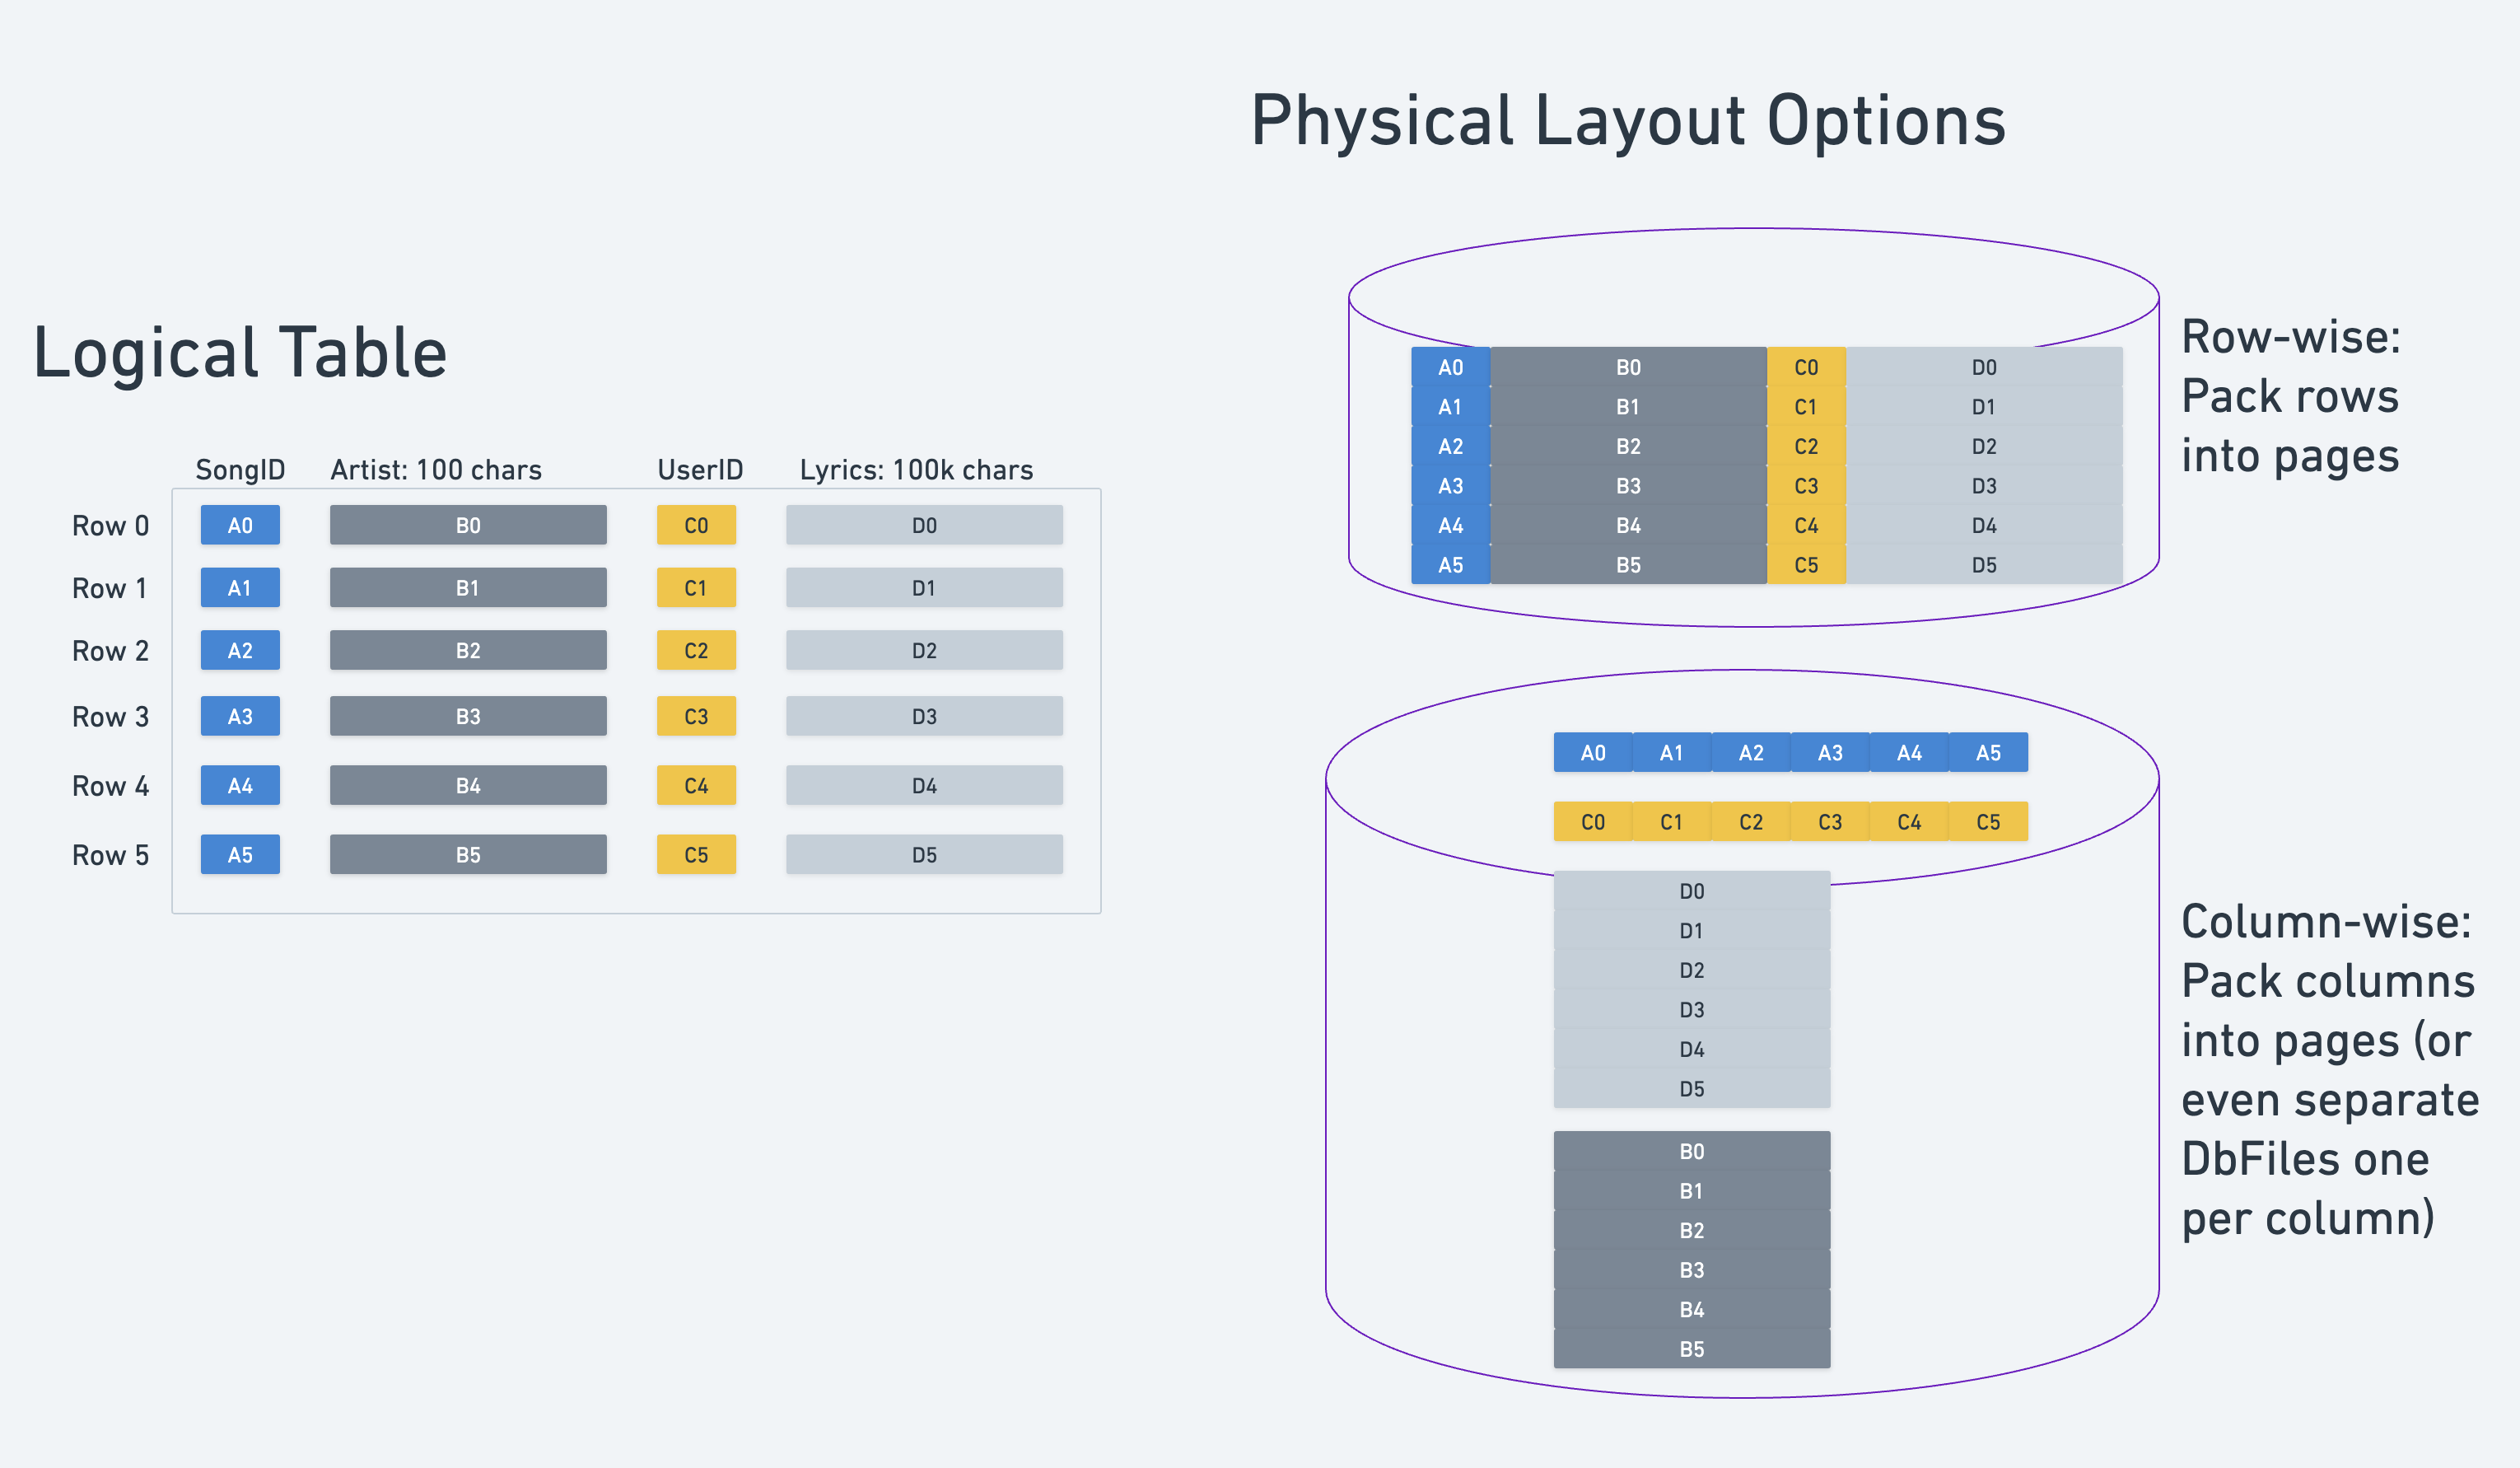

In [ ]:
import pandas as pd
import time, string, random, os

def generate_large_string(n):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=n))

# Generate a simple dataset with 4 columns and 100000 rows
n = 100000
df = pd.DataFrame({
    'song_id': [20 + (i % 30) for i in range(1, n)],
    'artist': [generate_large_string(100) for i in range(1, n)],
    'listencount': [50000 + (i * 10) for i in range(1, n)],
    'lyrics': [generate_large_string(1000) for i in range(1, n)],

})

# Simulate saving row-based storage using CSV
df.to_csv('row_based_storage.csv', index=False)

# Simulate saving column-based storage using Parquet
df.to_parquet('column_based_storage.parquet')

# Function to print the size of files in bytes
csv_size = os.path.getsize('row_based_storage.csv')
parquet_size = os.path.getsize('column_based_storage.parquet')
print(f"CSV file size: {csv_size} bytes")
print(f"Parquet file size: {parquet_size} bytes")

In [ ]:
# Function to query specific columns and save output, then check output size for CSV
def query_row_based_csv():
    start_time = time.time()
    df_csv = pd.read_csv('row_based_storage.csv',
                         usecols=['song_id', 'listencount', ])  # Only load listencount and song_id
    end_time = time.time()

    df_csv.to_csv('csv_output.csv', index=False)  # Save the queried result
    output_size = os.path.getsize('csv_output.csv')  # Check the size of the output file
    return df_csv, end_time - start_time, output_size

# Function to query specific columns and save output, then check output size for Parquet
def query_column_based_parquet():
    start_time = time.time()
    df_parquet = pd.read_parquet('column_based_storage.parquet',
                                 columns=['song_id', 'listencount'])  # Only load listencount and song_id
    end_time = time.time()
    return df_parquet, end_time - start_time

# Query and time for row-based storage (CSV)
csv_result, csv_time, csv_output_size = query_row_based_csv()
print(f"Row-based query time (CSV): {csv_time:.6f} seconds")

# Query and time for column-based storage (Parquet)
parquet_result, parquet_time = query_column_based_parquet()
print(f"Column-based query time (Parquet): {parquet_time:.6f} seconds")

print(f"Output size/Table size: {csv_output_size/csv_size} ")

# Test code below


In [ ]:
import math
import pandas as pd
from IPython.core.display import HTML

# Function to compute fanout and index structures with simplified B+ tree height
def compute_values(M, k, p, d, n_values):
    results = []

    # Iterate over each n value (number of tuples)
    for n in n_values:
        # Fanout (f)
        f = M // (k + p)

        # Number of data pages (N)
        N = math.ceil(n * d / M)

        # Hash Index (Unsorted)
        hash_unsorted_pages = math.ceil(n / f)

        # Hash Index (Sorted)
        hash_sorted_pages = math.ceil(N / f)

        # B+ Tree (Unsorted) height
        bplus_unsorted_height = math.ceil(math.log(n, f))

        # B+ Tree (Sorted) height
        bplus_sorted_height = math.ceil(math.log(N, f))

        # Append the results
        results.append({
            "k (Key Size)": k,
            "n (Number of Tuples)": n,
            "fanout (f)": f,
            "data pages (N)": N,
            "hash_index_unsorted_pages": hash_unsorted_pages,
            "hash_index_sorted_pages": hash_sorted_pages,
            "bplus_unsorted_height": bplus_unsorted_height,
            "bplus_sorted_height": bplus_sorted_height
        })

    return results

# Parameters
p = 8  # Pointer size in bytes (constant)
d = 1024  # Data row size in bytes
n_values = [10**6, 10**9, 10**12]  # Number of tuples from 1M to 1 trillion

# Configurations to test
configurations = [
    {"M": 64 * 1024 * 1024, "k_values": [8, 1024]},  # M = 64 MB
]

# Store results
all_results = []

# Run for each configuration of M and k values
for config in configurations:
    M = config["M"]
    for k in config["k_values"]:
        results = compute_values(M, k, p, d, n_values)
        all_results.extend(results)

# Convert results to DataFrame
df = pd.DataFrame(all_results)

# Display DataFrame as an HTML table
html = df.to_html(index=False)
display(HTML(html))
